In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# 데이터 로드
train = pd.read_csv('filtering_DATASET.csv') # if data type is mixed : , dtype=str
test = pd.read_csv("test_with_nan_mean_setting.csv")

In [2]:
unique_values = train['SUBCLASS'].unique()
print(unique_values.shape)

x_train = train.drop(columns=['SUBCLASS', 'ID'])
print(x_train.shape)

x_test = test.drop(columns=['ID'])
print(x_test.shape)

# 레이블 인코딩 (26종의 암을 숫자로 변환)
y = train['SUBCLASS']   # 암종 라벨
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

(26,)
(43257, 4384)
(2546, 4384)


In [3]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

In [4]:
# 데이터셋과 데이터로더 생성
train_dataset = TensorDataset(x_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(x_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
# DNN 모델 정의
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 하이퍼파라미터 설정
input_size = x_train.shape[1]  # 입력 피처 수
num_classes = len(np.unique(y))  # 클래스 수
learning_rate = 0.001
num_epochs = 70

In [7]:
#weight_decay = 1e-5  # L2 정규화 (weight decay)

# 모델, 손실 함수, 옵티마이저 정의
model = DNN(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # , weight_decay=weight_decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# early stop & acc visualization setting
best_loss = float('inf')
early_stop_counter = 0
patience = 5
loss_list = []
acc_list = []

# 모델 학습
model.train()
for epoch in range(num_epochs):
    correct_total = 0
    n_iter = 0
    loss_total = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        pred = outputs.argmax(dim=-1)
        correct_total += pred.eq(labels).sum().item()
        n_iter += 1

    epoch_loss = loss_total / n_iter
    epoch_acc = correct_total / len(x_train) * 100

    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # 학습률 스케줄러 업데이트
    scheduler.step()
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch [1/70], Loss: 1.6433, Accuracy: 47.06%
Epoch [2/70], Loss: 1.1621, Accuracy: 68.95%
Epoch [3/70], Loss: 1.0395, Accuracy: 79.15%
Epoch [4/70], Loss: 0.3309, Accuracy: 83.74%
Epoch [5/70], Loss: 0.4645, Accuracy: 86.15%
Epoch [6/70], Loss: 0.0791, Accuracy: 88.02%
Epoch [7/70], Loss: 0.2772, Accuracy: 89.07%
Epoch [8/70], Loss: 0.0973, Accuracy: 89.84%
Epoch [9/70], Loss: 0.3038, Accuracy: 90.65%
Epoch [10/70], Loss: 0.1897, Accuracy: 90.88%
Epoch [11/70], Loss: 0.2623, Accuracy: 91.17%
Epoch [12/70], Loss: 0.3587, Accuracy: 91.46%
Epoch [13/70], Loss: 0.3103, Accuracy: 91.74%
Epoch [14/70], Loss: 0.4032, Accuracy: 91.86%
Epoch [15/70], Loss: 0.2862, Accuracy: 91.99%
Epoch [16/70], Loss: 0.2438, Accuracy: 92.13%
Epoch [17/70], Loss: 0.0499, Accuracy: 92.25%
Epoch [18/70], Loss: 0.2028, Accuracy: 92.25%
Epoch [19/70], Loss: 0.4508, Accuracy: 92.36%
Epoch [20/70], Loss: 0.3628, Accuracy: 92.32%
Epoch [21/70], Loss: 0.1422, Accuracy: 92.44%
Epoch [22/70], Loss: 0.2495, Accuracy: 92.4

In [28]:
# Save the model's state dictionary (parameters)
torch.save(model.state_dict(), './DNN_model_weights.pth')

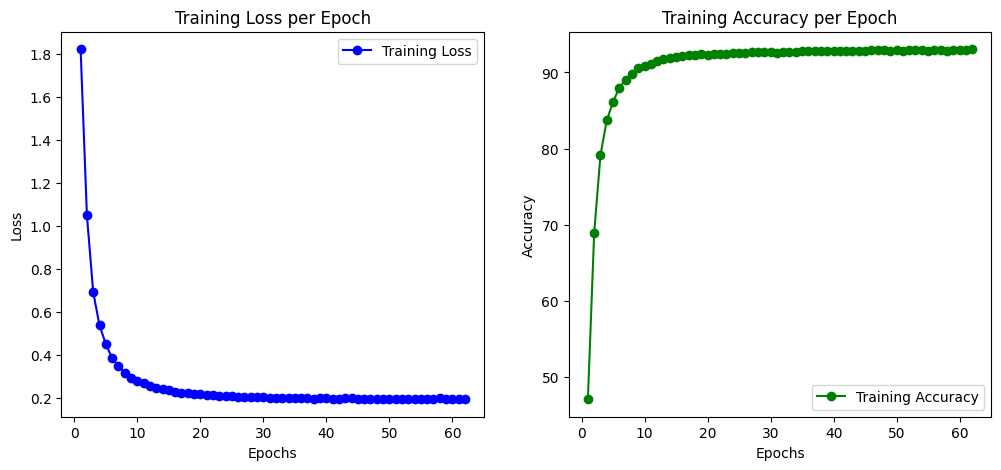

In [8]:
import matplotlib.pyplot as plt

# 학습 손실 및 정확도 시각화
epochs = range(1, len(loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, 'go-', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
import torch

# 모델 평가
model.eval()
predictions = []

# 예측 수행
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # 각 샘플의 최대 확률을 가진 클래스 예측
        predictions.extend(predicted.cpu().numpy())  # predicted 값을 리스트에 추가

# predictions 리스트는 라벨 인코딩 된 클래스 값으로 변환
original_labels = label_encoder.inverse_transform(predictions)

# 샘플 제출 파일 로드
submission = pd.read_csv("./sample_submission.csv")

# 'SUBCLASS' 열에 예측된 레이블 추가
submission["SUBCLASS"] = original_labels

# 제출 파일 저장
submission.to_csv('./submission/filteringDATASET_nan.csv', encoding='UTF-8-sig', index=False)

unique_values = submission['SUBCLASS'].value_counts()
print(unique_values)
print(unique_values.shape)

print("Submission file saved as 'submission.csv'")

SUBCLASS
BRCA      307
COAD      269
STES      246
GBMLGG    180
KIPAN     162
LUAD      143
KIRC      130
SKCM      128
LIHC      109
THCA       99
HNSC       99
OV         84
PAAD       77
PRAD       70
SARC       64
LGG        57
CESC       57
BLCA       55
UCEC       55
LAML       39
TGCT       29
PCPG       26
LUSC       21
THYM       17
ACC        13
DLBC       10
Name: count, dtype: int64
(26,)
Submission file saved as 'submission.csv'
